<a href="https://colab.research.google.com/github/wilsonfmjr/PPGEEC2321---REDES-NEURAIS-E-DEEP-LEARNING/blob/main/Questao_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - IMPORTAÇÃO DE BIBLIOTECAS

In [ ]:
import pandas as pd               # Para manipulação de planilhas e tabelas
import numpy as np                # Para operações numéricas
from sklearn.cluster import KMeans  # Algoritmo de agrupamento K-means
import matplotlib.pyplot as plt   # Para visualização de gráficos
from mpl_toolkits.mplot3d import Axes3D  # Visualização 3D
from scipy.spatial.distance import cdist

# 2 - CARREGAMENTO DOS DADOS

In [ ]:
# Caminho da pasta com o dataFrame
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel("/content/drive/My Drive/Dataset3/Dados_Q3.xlsx", sheet_name="Planilha1")

# Exibe as primeiras linhas do DataFrame
print(df)

Mounted at /content/drive
    Amostra    x1    x2    x3
0         1  7.82 -4.58 -3.97
1         2 -6.68  3.16  2.71
2         3  4.36  2.19  2.09
3         4  6.72  0.88  2.80
4         5 -8.64 -3.06  3.50
5         6 -6.87  0.57 -5.45
6         7  4.47 -2.62  5.76
7         8  6.73 -2.01  4.18
8         9 -7.71  2.34 -6.33
9        10 -6.91 -0.49 -5.68
10       11  6.18 -2.81  5.82
11       12  6.72 -0.93 -4.04
12       13 -6.25 -0.26  0.56
13       14 -6.94 -1.22  1.13
14       15  8.09  0.20  2.25
15       16  6.81  0.17 -4.15
16       17 -5.19  4.24  4.04
17       18 -6.38 -1.74  1.43
18       19  4.08  1.30  5.33
19       20  6.27  0.93 -2.78


# 3 - APLICAÇÃO DO K-MEANS (3 CLUSTERS) COM INICIALIZAÇÃO ALEATÓRIA



In [ ]:
# Extrai apenas as colunas numéricas para clustering
X = df[['x1', 'x2', 'x3']].values

# Definir a semente para gerar sempre os mesmos números aleatórios
np.random.seed(42)

# Inicialização com números aleatórios entre 0 e 1
centroids = np.random.rand(3, 3)

# Salvar histórico de centróides por iteração
centroids_history = [centroids.copy()]

# EXECUÇÃO MANUAL DO K-MEANS
max_iter = 100
for i in range(max_iter):
    # Atribuição: calcular distâncias e atribuir rótulo do cluster mais próximo
    distances = cdist(X, centroids)
    labels = np.argmin(distances, axis=1)

    # Atualização: recalcular centróides
    new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(3)])

    # Salvar histórico
    centroids_history.append(new_centroids.copy())

    # Verificar convergência
    if np.allclose(centroids, new_centroids, atol=1e-4):
        break
    centroids = new_centroids

df['Cluster'] = labels
centroids_final = centroids
centroids_history = np.array(centroids_history)

# Exibe os centróides
print("Centróides dos clusters:")
print(centroids_final)

Centróides dos clusters:
[[ 5.80428571 -0.41        4.03285714]
 [ 6.905      -1.1025     -3.735     ]
 [-6.84111111  0.39333333 -0.45444444]]



## 3.1 - VISUALIZAÇÃO 3D


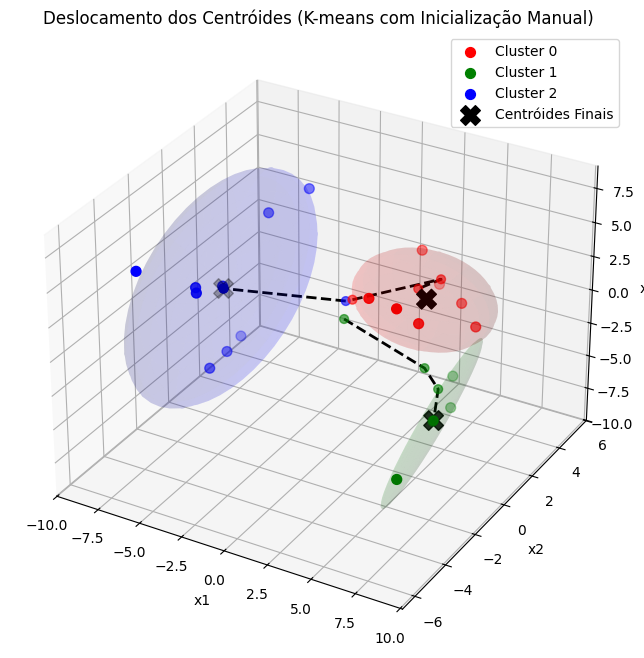

In [ ]:
# FUNÇÃO PARA PLOTAR ELOIPSOIDES
def plot_cluster_envelope(ax, points, centroid, color):
    cov = np.cov(points.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    radii = 2 * np.sqrt(eigvals)
    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot(eigvecs, [x[i, j], y[i, j], z[i, j]]) + centroid
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, alpha=0.1, linewidth=0)

# 5. PLOTAGEM 3D COM TRAJETÓRIA DOS CENTRÓIDES
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
cores = ['red', 'green', 'blue']

# Pontos por cluster e elipsoides
for cluster_id in range(3):
    pontos = df[df['Cluster'] == cluster_id][['x1', 'x2', 'x3']].values
    ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2],
               c=cores[cluster_id], label=f'Cluster {cluster_id}', s=50)
    plot_cluster_envelope(ax, pontos, centroids_final[cluster_id], cores[cluster_id])

# Trajetória dos centróides
for cluster_id in range(3):
    traj = centroids_history[:, cluster_id, :]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='black', linestyle='--', linewidth=2)
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], c=cores[cluster_id], s=40, marker='o', alpha=0.6)

# Últimos centróides marcados em X
ax.scatter(centroids_final[:, 0], centroids_final[:, 1], centroids_final[:, 2],
           c='black', marker='X', s=200, label='Centróides Finais')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Deslocamento dos Centróides (K-means com Inicialização Manual)')
ax.legend()
plt.show()

## 3.2 - ANÁLISE ESTATÍSTICA POR CLUSTER

In [ ]:
stats = []
for cluster_id in range(3):
    pontos = df[df['Cluster'] == cluster_id][['x1', 'x2', 'x3']].values
    centroid = centroids_final[cluster_id]
    n_pontos = len(pontos)
    media = pontos.mean(axis=0)
    desvio = pontos.std(axis=0)
    distancias = cdist(pontos, [centroid])
    media_distancia = distancias.mean()
    stats.append({
        'Cluster': cluster_id,
        'Amostras': n_pontos,
        'Média x1': media[0],
        'Média x2': media[1],
        'Média x3': media[2],
        'Desvio x1': desvio[0],
        'Desvio x2': desvio[1],
        'Desvio x3': desvio[2],
        'Distância Média ao Centróide': media_distancia
    })

df_stats = pd.DataFrame(stats)
print("\n📊 Estatísticas por Cluster:")
print(df_stats.round(2))


📊 Estatísticas por Cluster:
   Cluster  Amostras  Média x1  Média x2  Média x3  Desvio x1  Desvio x2  \
0        0         7      5.80     -0.41      4.03       1.41       1.89   
1        1         4      6.90     -1.10     -3.74       0.57       2.11   
2        2         9     -6.84      0.39     -0.45       0.90       2.27   

   Desvio x3  Distância Média ao Centróide  
0       1.53                          2.75  
1       0.56                          1.92  
2       3.94                          4.33  


# 4 - APLICAÇÃO DO K-MEANS (3 CLUSTERS) COM INICIALIZAÇÃO EM m1=(0,0,0)t, m2=(0,1,1)t, m3=(-1,1,2)t

In [ ]:
# Extrai apenas as colunas numéricas para clustering
X = df[['x1', 'x2', 'x3']].values

# Inicialização em m1=(-0.1,0,0.1)t, m2=(0,-0.1,0.1)t, m3=(-0.1,-0.1,0.1)t
centroids = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [-1, 1, 2]
], dtype=float)

# Salvar histórico de centróides por iteração
centroids_history = [centroids.copy()]

# EXECUÇÃO MANUAL DO K-MEANS
max_iter = 100
for i in range(max_iter):
    # Atribuição: calcular distâncias e atribuir rótulo do cluster mais próximo
    distances = cdist(X, centroids)
    labels = np.argmin(distances, axis=1)

    # Atualização: recalcular centróides
    new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(3)])

    # Salvar histórico
    centroids_history.append(new_centroids.copy())

    # Verificar convergência
    if np.allclose(centroids, new_centroids, atol=1e-4):
        break
    centroids = new_centroids

df['Cluster'] = labels
centroids_final = centroids
centroids_history = np.array(centroids_history)

# Exibe os centróides
print("Centróides dos clusters:")
print(centroids_final)

Centróides dos clusters:
[[ 6.905      -1.1025     -3.735     ]
 [ 5.80428571 -0.41        4.03285714]
 [-6.84111111  0.39333333 -0.45444444]]


## 4.1 - VISUALIZAÇÃO 3D

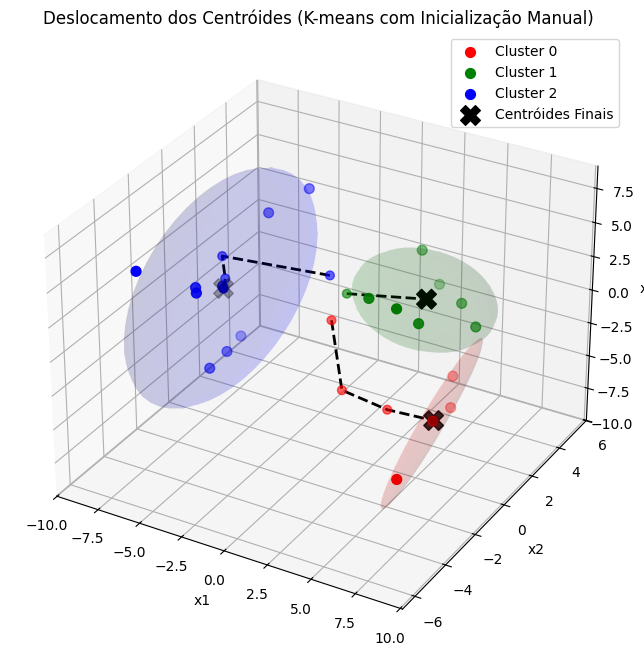

In [ ]:
# FUNÇÃO PARA PLOTAR ELOIPSOIDES
def plot_cluster_envelope(ax, points, centroid, color):
    cov = np.cov(points.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    radii = 2 * np.sqrt(eigvals)
    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot(eigvecs, [x[i, j], y[i, j], z[i, j]]) + centroid
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, alpha=0.1, linewidth=0)

# 5. PLOTAGEM 3D COM TRAJETÓRIA DOS CENTRÓIDES
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
cores = ['red', 'green', 'blue']

# Pontos por cluster e elipsoides
for cluster_id in range(3):
    pontos = df[df['Cluster'] == cluster_id][['x1', 'x2', 'x3']].values
    ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2],
               c=cores[cluster_id], label=f'Cluster {cluster_id}', s=50)
    plot_cluster_envelope(ax, pontos, centroids_final[cluster_id], cores[cluster_id])

# Trajetória dos centróides
for cluster_id in range(3):
    traj = centroids_history[:, cluster_id, :]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='black', linestyle='--', linewidth=2)
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], c=cores[cluster_id], s=40, marker='o', alpha=0.6)

# Últimos centróides marcados em X
ax.scatter(centroids_final[:, 0], centroids_final[:, 1], centroids_final[:, 2],
           c='black', marker='X', s=200, label='Centróides Finais')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Deslocamento dos Centróides (K-means com Inicialização Manual)')
ax.legend()
plt.show()

## 4.2 - ANÁLISE ESTATÍSTICA POR CLUSTER

In [ ]:
stats = []
for cluster_id in range(3):
    pontos = df[df['Cluster'] == cluster_id][['x1', 'x2', 'x3']].values
    centroid = centroids_final[cluster_id]
    n_pontos = len(pontos)
    media = pontos.mean(axis=0)
    desvio = pontos.std(axis=0)
    distancias = cdist(pontos, [centroid])
    media_distancia = distancias.mean()
    stats.append({
        'Cluster': cluster_id,
        'Amostras': n_pontos,
        'Média x1': media[0],
        'Média x2': media[1],
        'Média x3': media[2],
        'Desvio x1': desvio[0],
        'Desvio x2': desvio[1],
        'Desvio x3': desvio[2],
        'Distância Média ao Centróide': media_distancia
    })

df_stats = pd.DataFrame(stats)
print("\n📊 Estatísticas por Cluster:")
print(df_stats.round(2))


📊 Estatísticas por Cluster:
   Cluster  Amostras  Média x1  Média x2  Média x3  Desvio x1  Desvio x2  \
0        0         4      6.90     -1.10     -3.74       0.57       2.11   
1        1         7      5.80     -0.41      4.03       1.41       1.89   
2        2         9     -6.84      0.39     -0.45       0.90       2.27   

   Desvio x3  Distância Média ao Centróide  
0       0.56                          1.92  
1       1.53                          2.75  
2       3.94                          4.33  


# 5 - APLICAÇÃO DO K-MEANS (3 CLUSTERS) COM INICIALIZAÇÃO EM m1=(-0.1,0,0.1)t, m2=(0,-0.1,0.1)t, m3=(-0.1,-0.1,0.1)t.

In [ ]:
# Extrai apenas as colunas numéricas para clustering
X = df[['x1', 'x2', 'x3']].values

# Inicialização em m1=(-0.1,0,0.1)t, m2=(0,-0.1,0.1)t, m3=(-0.1,-0.1,0.1)t
centroids = np.array([
    [-0.1, 0.0 , 0.1],
    [0.0, -0.1, 0.1],
    [-0.1, -0.1, 0.1]
], dtype=float)

# Salvar histórico de centróides por iteração
centroids_history = [centroids.copy()]

# EXECUÇÃO MANUAL DO K-MEANS
max_iter = 100
for i in range(max_iter):
    # Atribuição: calcular distâncias e atribuir rótulo do cluster mais próximo
    distances = cdist(X, centroids)
    labels = np.argmin(distances, axis=1)

    # Atualização: recalcular centróides
    new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(3)])

    # Salvar histórico
    centroids_history.append(new_centroids.copy())

    # Verificar convergência
    if np.allclose(centroids, new_centroids, atol=1e-4):
        break
    centroids = new_centroids

df['Cluster'] = labels
centroids_final = centroids
centroids_history = np.array(centroids_history)

# Exibe os centróides
print("Centróides dos clusters:")
print(centroids_final)

Centróides dos clusters:
[[-7.16333333  0.80666667 -5.82      ]
 [ 6.20454545 -0.66181818  1.20818182]
 [-6.68        0.18666667  2.22833333]]


## 5.1 - VISUALIZAÇÃO 3D

/tmp/ipython-input-51-2682865176.py:7: RuntimeWarning: invalid value encountered in sqrt
  radii = 2 * np.sqrt(eigvals)


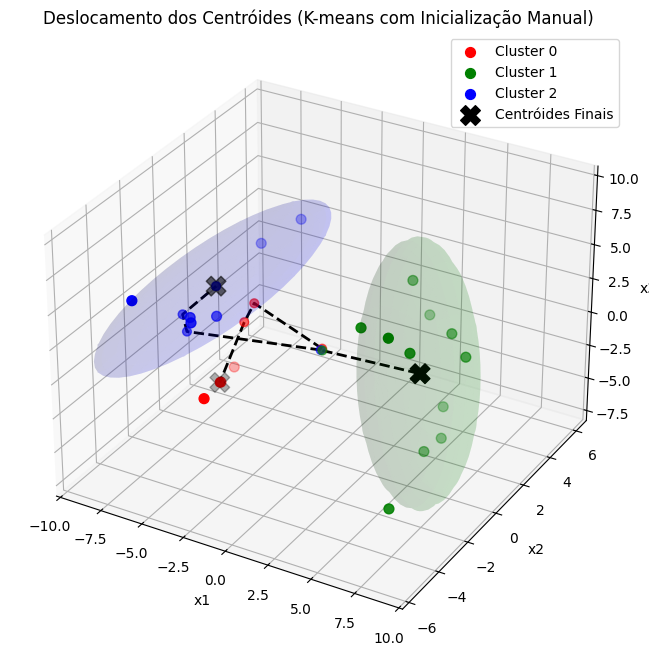

In [ ]:
# FUNÇÃO PARA PLOTAR ELOIPSOIDES
def plot_cluster_envelope(ax, points, centroid, color):
    cov = np.cov(points.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    radii = 2 * np.sqrt(eigvals)
    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i, j], y[i, j], z[i, j]] = np.dot(eigvecs, [x[i, j], y[i, j], z[i, j]]) + centroid
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, alpha=0.1, linewidth=0)

# 5. PLOTAGEM 3D COM TRAJETÓRIA DOS CENTRÓIDES
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
cores = ['red', 'green', 'blue']

# Pontos por cluster e elipsoides
for cluster_id in range(3):
    pontos = df[df['Cluster'] == cluster_id][['x1', 'x2', 'x3']].values
    ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2],
               c=cores[cluster_id], label=f'Cluster {cluster_id}', s=50)
    plot_cluster_envelope(ax, pontos, centroids_final[cluster_id], cores[cluster_id])

# Trajetória dos centróides
for cluster_id in range(3):
    traj = centroids_history[:, cluster_id, :]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='black', linestyle='--', linewidth=2)
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], c=cores[cluster_id], s=40, marker='o', alpha=0.6)

# Últimos centróides marcados em X
ax.scatter(centroids_final[:, 0], centroids_final[:, 1], centroids_final[:, 2],
           c='black', marker='X', s=200, label='Centróides Finais')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Deslocamento dos Centróides (K-means com Inicialização Manual)')
ax.legend()
plt.show()

## 5.2 - ANÁLISE ESTATÍSTICA POR CLUSTER

In [ ]:
stats = []
for cluster_id in range(3):
    pontos = df[df['Cluster'] == cluster_id][['x1', 'x2', 'x3']].values
    centroid = centroids_final[cluster_id]
    n_pontos = len(pontos)
    media = pontos.mean(axis=0)
    desvio = pontos.std(axis=0)
    distancias = cdist(pontos, [centroid])
    media_distancia = distancias.mean()
    stats.append({
        'Cluster': cluster_id,
        'Amostras': n_pontos,
        'Média x1': media[0],
        'Média x2': media[1],
        'Média x3': media[2],
        'Desvio x1': desvio[0],
        'Desvio x2': desvio[1],
        'Desvio x3': desvio[2],
        'Distância Média ao Centróide': media_distancia
    })

df_stats = pd.DataFrame(stats)
print("\n📊 Estatísticas por Cluster:")
print(df_stats.round(2))


📊 Estatísticas por Cluster:
   Cluster  Amostras  Média x1  Média x2  Média x3  Desvio x1  Desvio x2  \
0        0         3     -7.16      0.81     -5.82       0.39       1.17   
1        1        11      6.20     -0.66      1.21       1.29       2.00   
2        2         6     -6.68      0.19      2.23       1.03       2.64   

   Desvio x3  Distância Média ao Centróide  
0       0.37                          1.19  
1       3.94                          4.41  
2       1.28                          2.90  
